# Estudo de caso 1 - Previsão de Preço de Ações

Features comumente uteis para a previsão do preço das são estes

1. Ativos correlacionados
    * Uma organização depende de e interage com muito fatores externos, incluindo concorrentes, clientes, e economia global, a situação geopolitica, politicas fiscais e monetarias, acesso ao capital e assim por diante.
2. Indicadores tecnicos
    * Media movel, media movel exponencial e momentum
3. Analise fundementalista
4. Relatorio de desempenho
    * Relatorio anuais a trimestrais das empresas podem ser usadas para extrair ou determinar metricas-chave como ROE

5. Noticias

### Carregando dados e pacotes python

In [56]:
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet
)

from sklearn.tree      import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm       import SVR

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)

from sklearn.neural_network import MLPRegressor

# Para analise de dados e a avaliacao de modelos
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)

from sklearn.feature_selection import (
    SelectKBest,
    chi2, f_regression
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# RNA
import tensorflow as tf
import keras

Mais pacotes...

In [57]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import yfinance as yf

Carregando dados

In [58]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [78]:
stk_data = yf.download(stk_tickers, start='2015-01-01', auto_adjust=True)
ccy_data = web.DataReader(ccy_tickers, 'fred', start='2015-01-01')
idx_data = web.DataReader(idx_tickers, 'fred', start='2015-01-01')

[*********************100%***********************]  3 of 3 completed


> A target é o retorno semanal da ação da microsoft. Presume-se que o numero de dias uteuis para negociação por semana é cinco, e computamos o retorno usando esse parametro.


> As features são retornos defasados  dos cincos dias das ações, moedas e indices.

In [80]:
period = 5

In [81]:
Y = stk_data.loc[:, ('Close','MSFT')].apply(lambda x: np.log(x)).diff(period).shift(-period)

In [82]:
Y.name = 'MSFT_pred'

In [83]:
Y

Date
2015-01-02    0.009154
2015-01-05    0.005811
2015-01-06    0.015433
2015-01-07   -0.005858
2015-01-08   -0.045350
                ...   
2025-08-04         NaN
2025-08-05         NaN
2025-08-06         NaN
2025-08-07         NaN
2025-08-08         NaN
Name: MSFT_pred, Length: 2666, dtype: float64

In [84]:
X1 = stk_data.loc[:, ('Close',('IBM', 'GOOGL'))].apply(lambda x: np.log(x)).diff(period)

In [85]:
X1.columns = X1.columns.droplevel()

In [86]:
X1

Ticker,IBM,GOOGL
Date,,
2015-01-02,NaN,NaN
2015-01-05,NaN,NaN
2015-01-06,NaN,NaN
2015-01-07,NaN,NaN
2015-01-08,NaN,NaN
...,...,...
2025-08-04,-0.043602,0.012693
2025-08-05,-0.045771,-0.005533
2025-08-06,-0.031142,-0.002241


In [88]:
X2 = ccy_data.loc[:, ('DEXJPUS', 'DEXUSUK')].apply(lambda x: np.log(x)).diff(period)
X3 = idx_data.loc[:, ('SP500', 'DJIA', 'VIXCLS')].apply(lambda x: np.log(x)).diff(period)

In [89]:
X4 = pd.concat([
    np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(i) \
    for i in [period, period*3, period*6, period*12]
], axis=1).dropna()

In [90]:
X4.columns = ['MSFT_DT', 'MSFT_DT3', 'MSFT_DT6', 'MSFT_DT12']

In [91]:
X = pd.concat([X1, X2, X3, X4], axis=1)

In [92]:
data = pd.concat([Y, X], axis=1).dropna().iloc[::period,:]

In [93]:
Y = data.loc[:, ~data.columns.isin(X.columns)]
X = data.loc[:, X.columns]

Analise dos dados

In [94]:
data.head(3)

,MSFT_pred,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_DT3,MSFT_DT6,MSFT_DT12
2015-08-17,-0.120339,-0.002811,0.045644,-0.001768,0.003339,-0.000827,-0.003981,0.062595,-0.000211,0.042523,0.063919,-0.002111
2015-08-24,0.043199,-0.085716,-0.115964,-0.047520,0.008491,-0.104825,-0.100264,1.140724,-0.120339,-0.109503,-0.081997,-0.110571
2015-08-31,0.008466,0.030343,0.046947,0.022518,-0.023671,0.040866,0.040542,-0.359765,0.043199,-0.077351,-0.068651,-0.051887


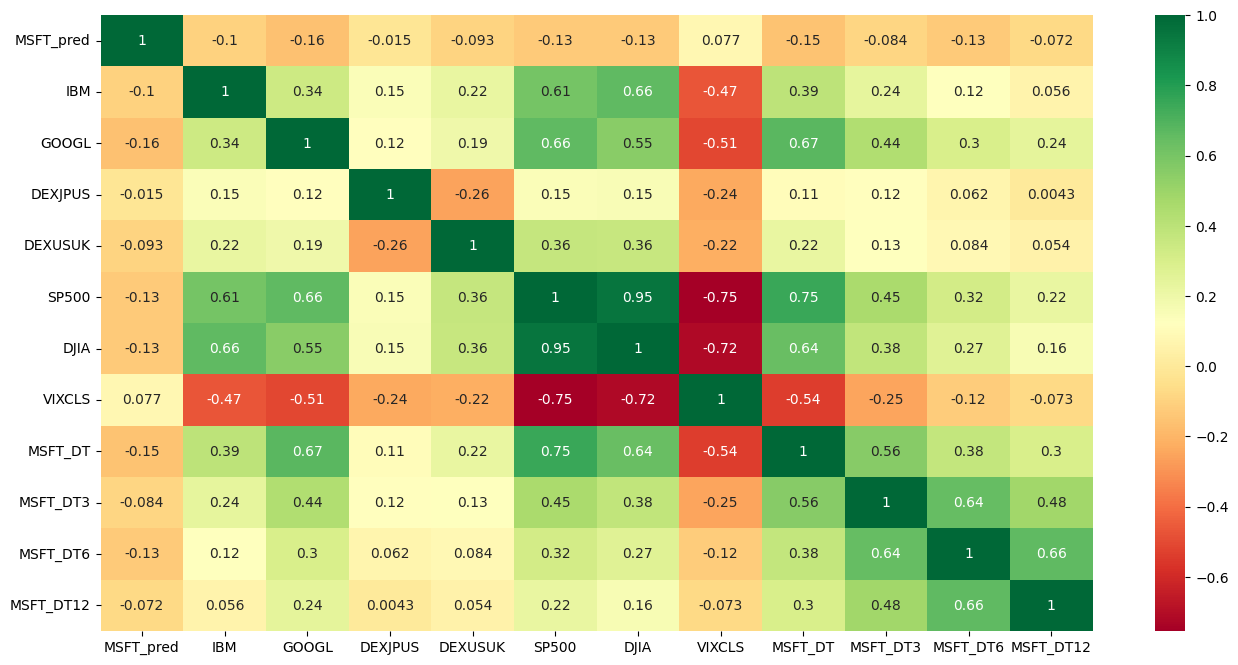

In [97]:
plt.figure(figsize=(16,8))
sns.heatmap(
    data.corr(),
    cmap='RdYlGn',
    annot=True
)
plt.show()

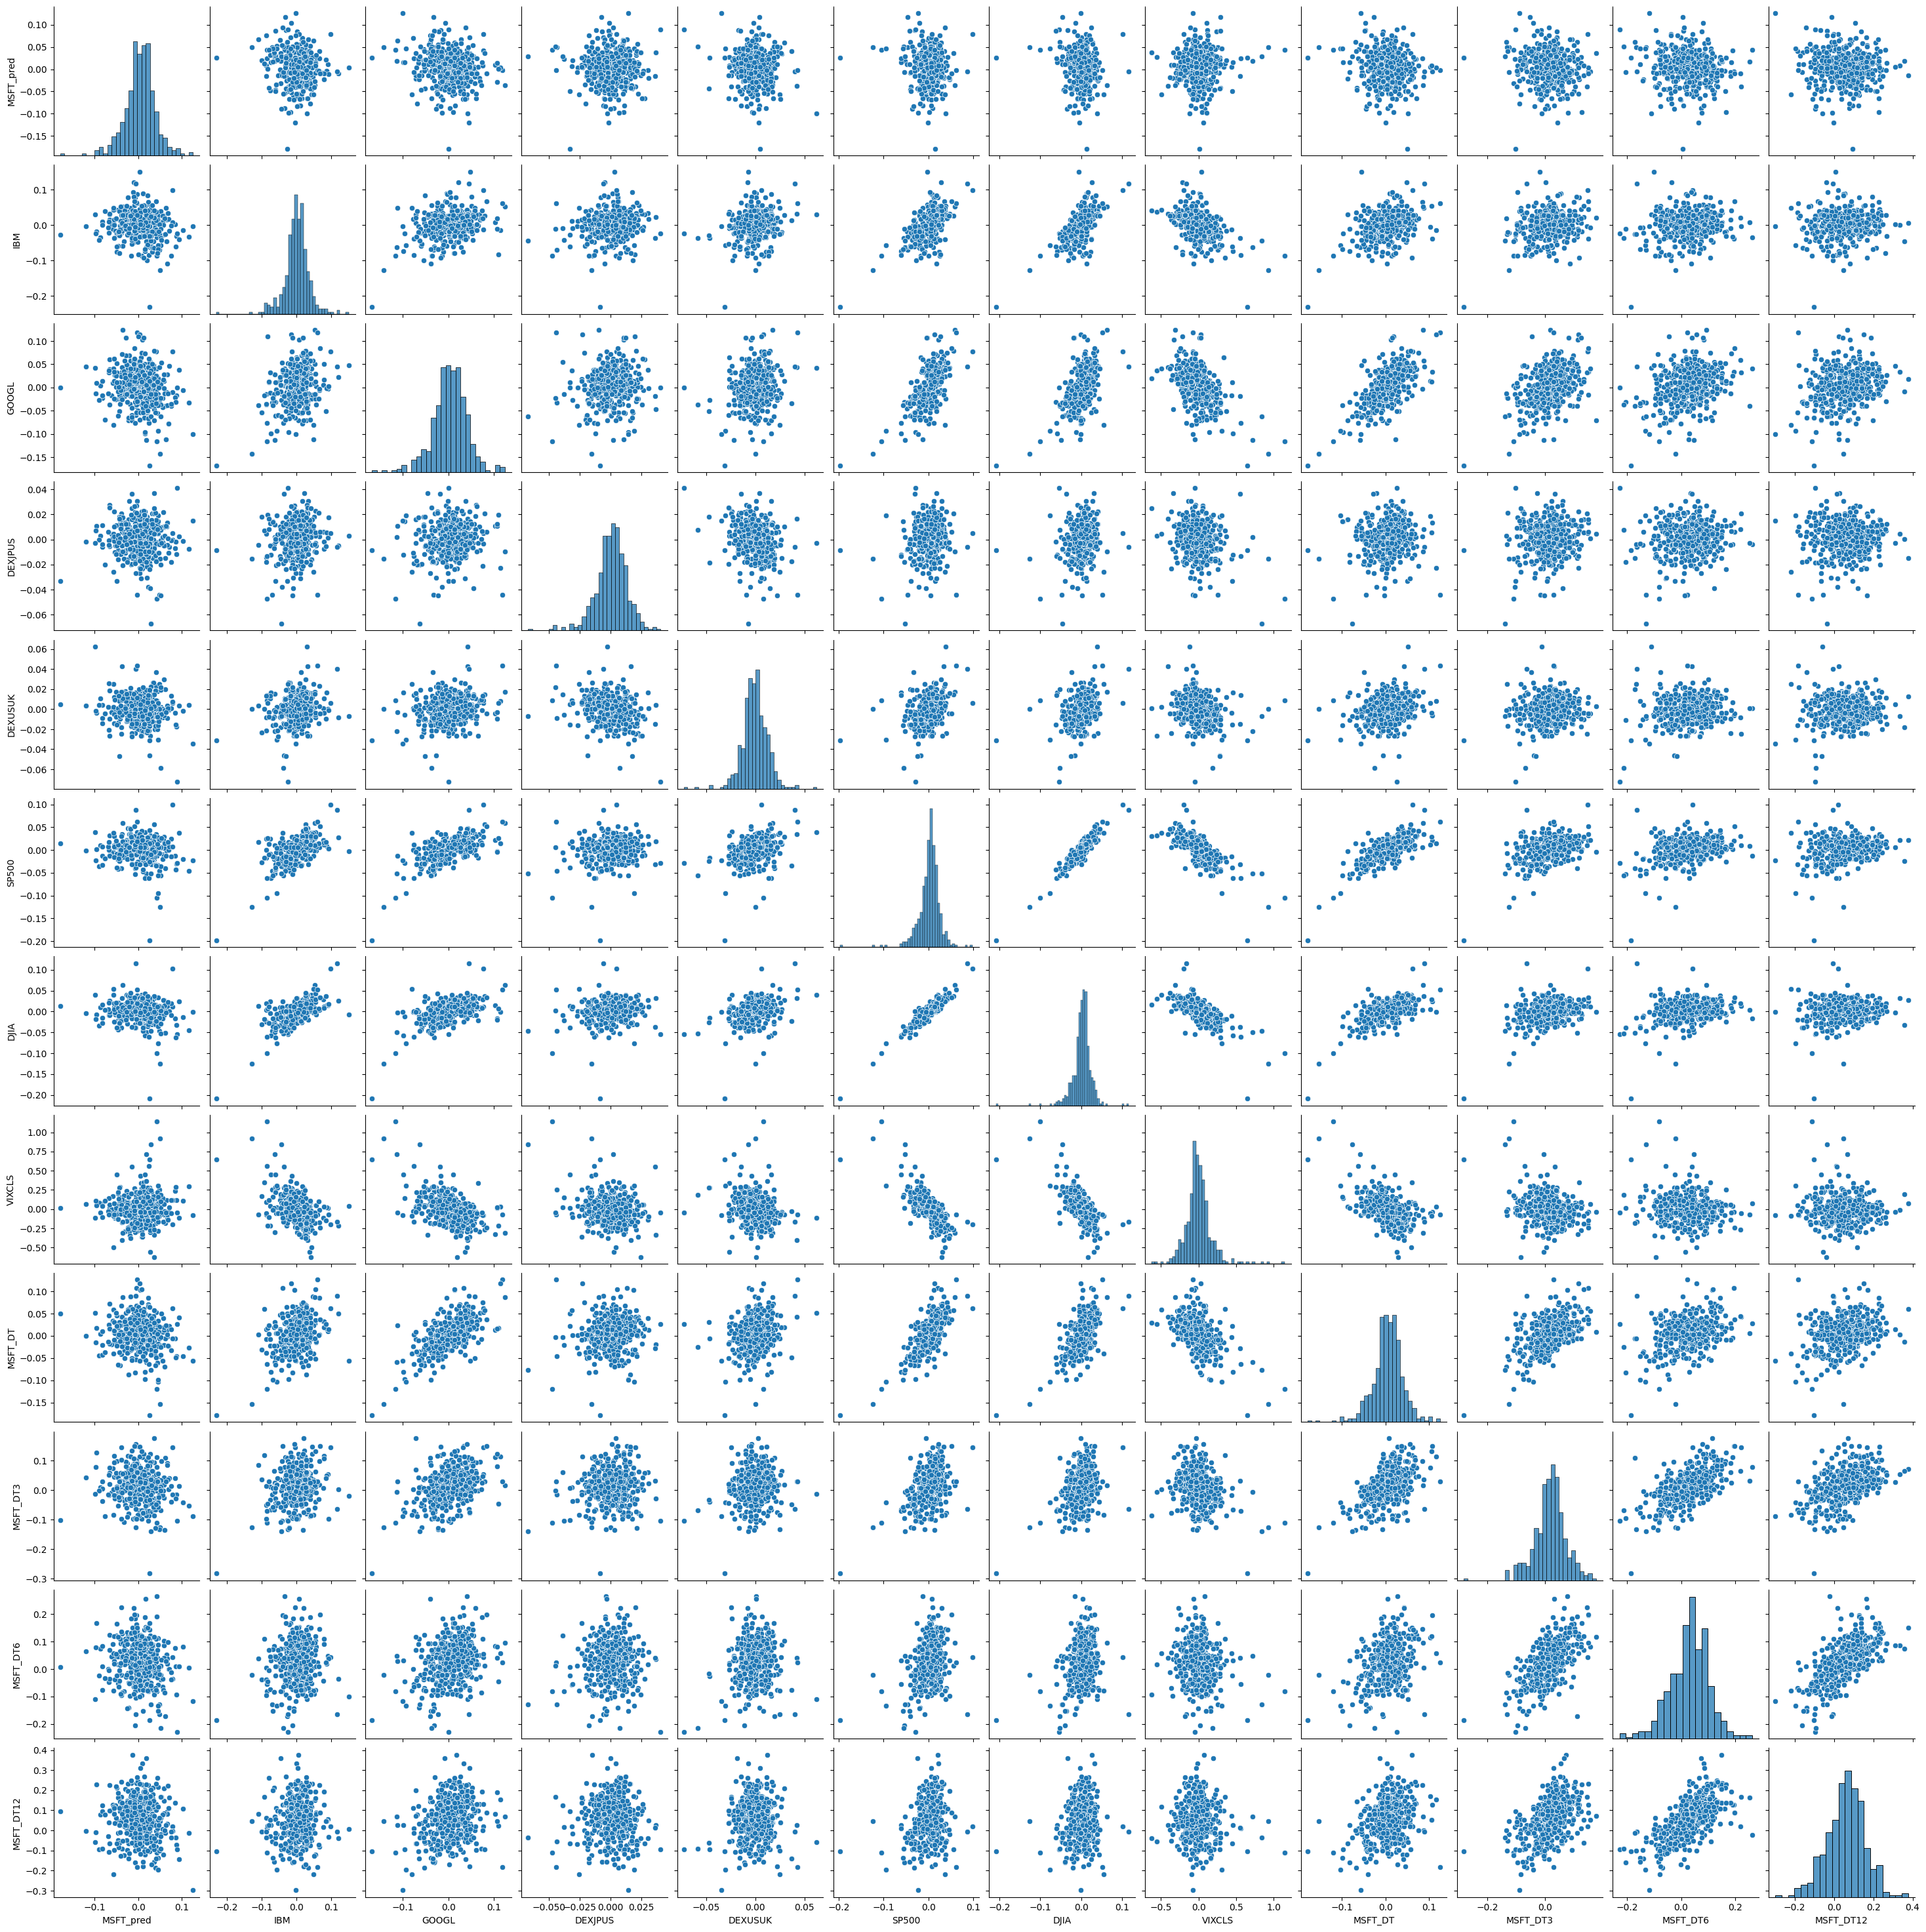

In [98]:
sns.pairplot(data)

In [101]:
res = sm.tsa.seasonal_decompose(Y, period=52)

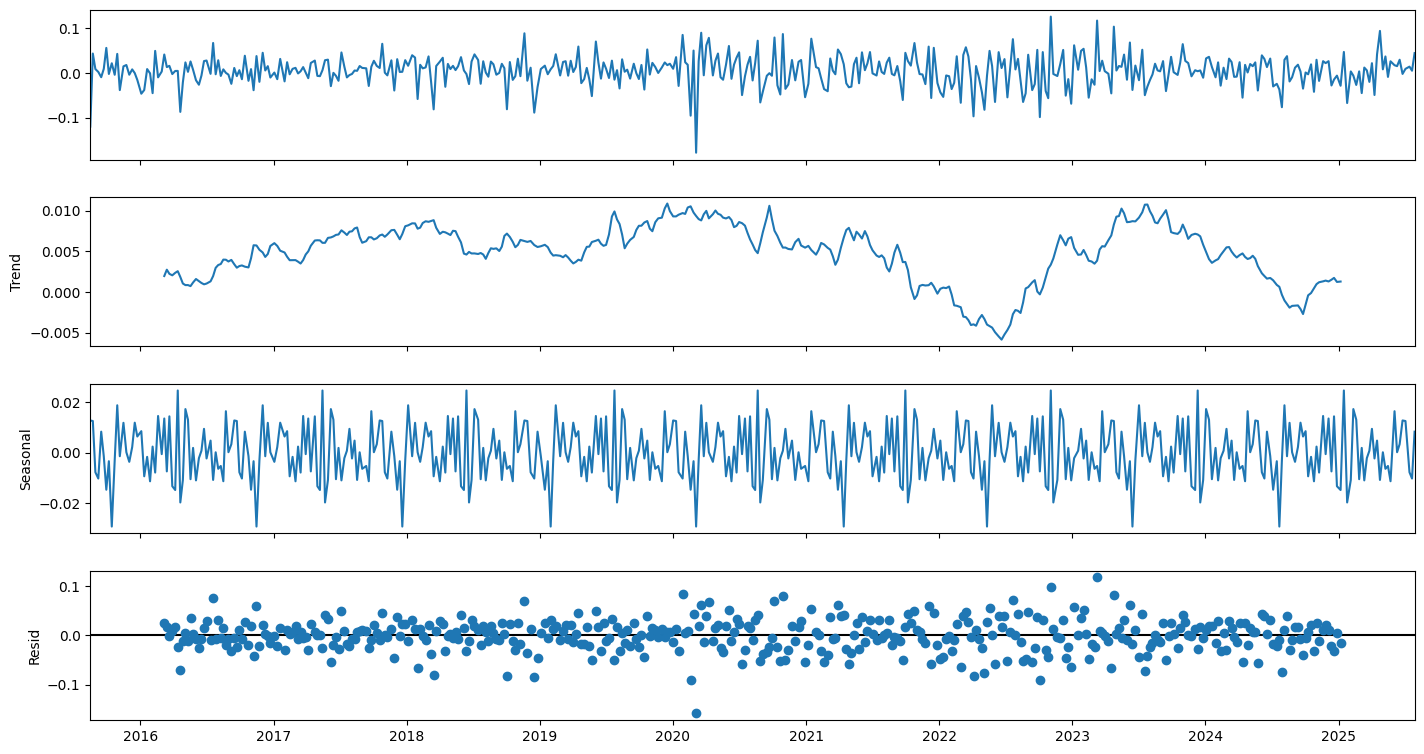

In [102]:
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

In [117]:
validation_size = .2

train_size = int(len(Y) * (1 - validation_size))

xtrain, xtest = X[:train_size].values, X[train_size:].values
ytrain, ytest = Y[:train_size].values, Y[train_size:].values
ytrain, ytest = ytrain.ravel(), ytest.ravel()

In [126]:
kfolds = 10
score = 'neg_mean_squared_error'

In [127]:
models = []

models.append(('LinearRegression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('KNeighbors', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('ExtraTrees', ExtraTreesRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('MLP', MLPRegressor()))

In [128]:
names, kfold_scores, test_results, train_results = [], [], [], []

for name, model in models:
    names.append(name)

    kfold = KFold(n_splits=kfolds, shuffle=True, random_state=12)

    cv_results = cross_val_score(model, xtrain, ytrain, cv=kfold, scoring=score)
    kfold_scores.append(cv_results)
    
    res = model.fit(xtrain, ytrain)
    train_results.append(mean_squared_error(ytrain, res.predict(xtrain)))
    test_results.append(mean_squared_error(ytest, res.predict(xtest)))

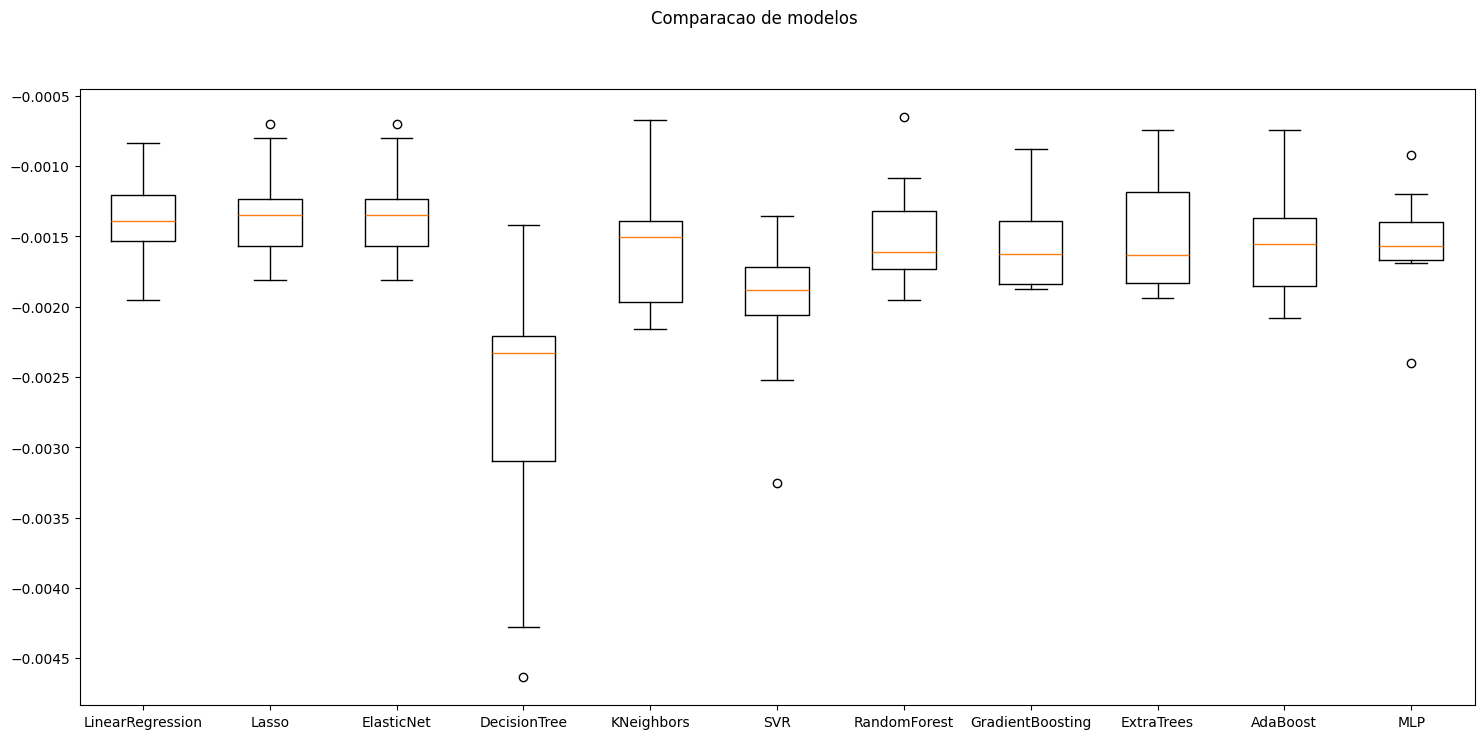

In [129]:
fig = plt.figure(figsize=(18,8))
fig.suptitle('Comparacao de modelos')
ax  = fig.add_subplot(111)

plt.boxplot(kfold_scores)
ax.set_xticklabels(names)
plt.show()

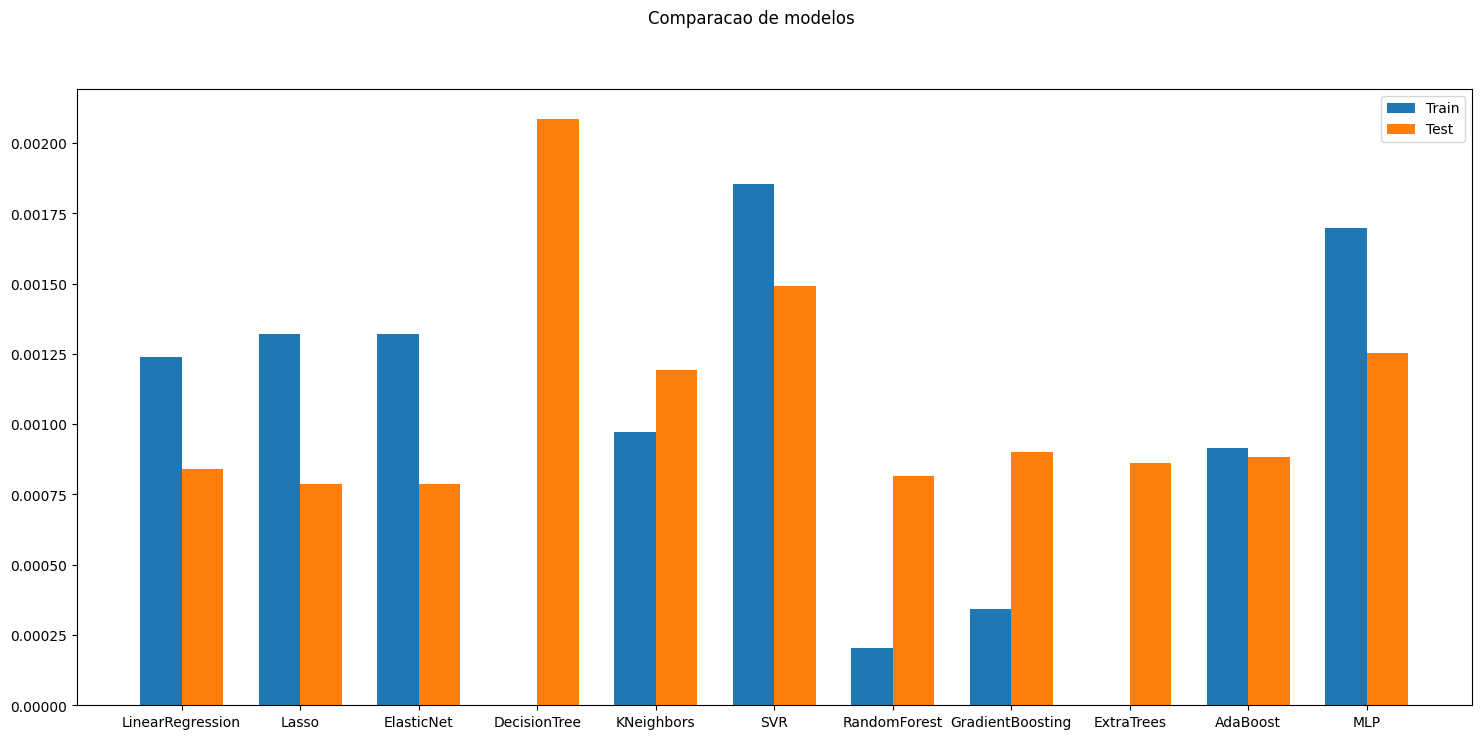

In [131]:
fig = plt.figure(figsize=(18,8))
fig.suptitle('Comparacao de modelos')
ax  = fig.add_subplot(111)

ind = np.arange(len(names))
width = 0.35

plt.bar(ind, train_results, width, label='Train')
plt.bar(ind + width, test_results, width, label='Test')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(names)
plt.legend()
plt.show()